## Table of Contents

1. [Overview](#overview)
2. [Setup and Prerequisites](#setup-and-prerequisites)
3. [Understanding Temperature Differences](#understanding-temperature-differences)
   - 3.1 [Basic Concept](#basic-concept)
   - 3.2 [Usage Examples](#usage-examples)
4. [Method 1: Demand-Based Mass Flow Estimation](#method-1-demand-based-mass-flow-estimation)
   - 4.1 [Basic Usage](#basic-usage)
   - 4.2 [Comparing Load Scenarios](#comparing-load-scenarios)
5. [Method 2: Complete Hydronic Network Sizing](#method-2-complete-hydronic-network-sizing)
6. [Visualization: Pipe Diameter Analysis](#visualization-pipe-diameter-analysis)
7. [Best Practices & Recommended Workflow](#best-practices--recommended-workflow)

---

## Overview

This notebook demonstrates the new **demand-based mass flow estimation** and **hydronic sizing** capabilities in the uesgraph package. These functions provide:

- **Physically accurate mass flow calculations** based on individual demand nodes
- **Automated pipe sizing** using manufacturer catalogs
- **Robust network design** using maximum flow principles
- **Flexible scenario analysis** (peak vs average loads)

**Key Benefits:**
- No more manual mass flow calculations
- Automatic diameter selection from pipe catalogs
- Support for different temperature differences per node
- Comprehensive error handling and validation

---

## Setup and Prerequisites

In [ ]:

import uesgraphs as ug

from uesgraphs.examples import e1_readme_example as e1

import os

from datetime import datetime

workspace = e1.workspace_example("e14")

dir_ues = os.path.dirname(os.path.dirname(workspace))
pinola_json = os.path.join(dir_ues, "workspace", "e11", "inputs","test_modelgen", "Pinola", "nodes.json")

if not os.path.exists(pinola_json):
    raise FileNotFoundError(f"File {pinola_json} not found."
                            "Please run example e11 to generate network topology.")

graph = ug.UESGraph()
graph.from_json(path=pinola_json,network_type="heating")
print(f"Network has {len(graph.nodelist_building)} building nodes")

read nodes...
******
 input_ids were {'buildings': None, 'nodes': '24f91801-215e-4b3d-9426-4ec51de13368', 'pipes': None, 'supplies': None}
...finished
Network has 5 building nodes


In [2]:
# Package contains proper methods for hydronic sizing

import uesgraphs.systemmodels.utilities as sysm_ut


## Understanding Temperature Differences

### Basic Concept


The temperature difference (dT) between supply and return flow is critical for mass flow calculation:

```
m_flow = thermal_load / (cp * dT)
```

**Our functions are flexible** - you can use any attribute name for temperature differences, making them compatible with both new and existing networks.


### Usage Examples


#### Example 1: Using dT_Network (recommended for new networks)


In [3]:
for node in graph.nodelist_building:
    if not graph.nodes[node].get("is_supply_heating", False):
        graph.nodes[node]["dT_Network"] = 30.0  # Kelvin

# Use in function
graph = sysm_ut.estimate_m_flow_demand_based(
    graph=graph,
    dT_attribute="dT_Network"  # Specify the attribute name
)

# is equal to

graph = sysm_ut.estimate_m_flow_demand_based(
    graph=graph,
)


Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\_20250526_170428.log
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\_20250526_170428.log


#### Example 2: Using dT_design (for existing/legacy networks)

In [4]:
# Some existing networks already have dT_design set
# No need to change anything - just specify the attribute:

graph = sysm_ut.estimate_m_flow_demand_based(
    graph=graph,
    dT_attribute="dT_design"  # Use existing attribute
)

Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\_20250526_170428.log


#### Example 3: Custom dT per building type

In [5]:
for node in graph.nodelist_building:
    if not graph.nodes[node].get("is_supply_heating", False):
        heat_demand = max(graph.nodes[node].get('input_heat', [0]))
        if heat_demand > 50000:
            graph.nodes[node]["dT_custom"] = 35.0    # Efficient systems
        else:
            graph.nodes[node]["dT_custom"] = 25.0    # Standard systems

# Use custom attribute
graph = sysm_ut.estimate_m_flow_demand_based(
    graph=graph,
    dT_attribute="dT_custom"
)

Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\_20250526_170428.log


**💡 Key Point**: The `dT_attribute` parameter makes our functions compatible with any existing temperature difference naming convention.


## Method 1: Demand-Based Mass Flow Estimation

### Basic-Usage

In [6]:
import numpy as np
# Method 1: Basic demand-based mass flow estimation
print("=== Method 1: Demand-based Mass Flow Estimation ===")

# Estimate mass flows based on peak demand
graph_method1 = sysm_ut.estimate_m_flow_demand_based(
    graph=graph,
    network_type="heating",
    dT_attribute="dT_design",
    load_scenario="peak_load",
    demand_attribute="input_heat"
)

# Inspect the results
print(f"\nMass flow estimation completed!")
print(f"Total edges with mass flow data: {len([e for e in graph_method1.edges if 'm_flow_peak_load' in graph_method1.edges[e]])}")

# Show mass flow statistics
mass_flows = [graph_method1.edges[e]['m_flow_peak_load'] 
              for e in graph_method1.edges 
              if 'm_flow_peak_load' in graph_method1.edges[e]]

if mass_flows:
    print(f"Mass flow statistics:")
    print(f"  - Maximum: {max(mass_flows):.4f} kg/s")
    print(f"  - Minimum: {min(mass_flows):.4f} kg/s")
    print(f"  - Average: {np.mean(mass_flows):.4f} kg/s")

=== Method 1: Demand-based Mass Flow Estimation ===
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\_20250526_170428.log

Mass flow estimation completed!
Total edges with mass flow data: 8
Mass flow statistics:
  - Maximum: 0.4460 kg/s
  - Minimum: 0.1110 kg/s
  - Average: 0.2176 kg/s


### Comparing Load Scenarios

In [7]:
import pandas as pd

# Compare different load scenarios
print("\n=== Comparing Load Scenarios ===")

print("Using single graph with different mass flow attributes...")



# Calculate for peak load (adds m_flow_peak_load to edges)
graph = sysm_ut.estimate_m_flow_demand_based(
    graph=graph,
    load_scenario="peak_load",
    dT_attribute="dT_design"
)

# Calculate for average load (adds m_flow_average_load to edges)
graph = sysm_ut.estimate_m_flow_demand_based(
    graph=graph,
    load_scenario="average_load", 
    dT_attribute="dT_design"
)

# Create comparison dataframe
comparison_data = []
for edge in graph.edges:
    peak_flow = graph.edges[edge].get('m_flow_peak_load', 0)
    avg_flow = graph.edges[edge].get('m_flow_average_load', 0)
    comparison_data.append({
        'edge': f"{edge[0]}-{edge[1]}",
        'peak_load_kg_s': peak_flow,
        'average_load_kg_s': avg_flow,
        'ratio_peak_to_avg': peak_flow / avg_flow if avg_flow > 0 else np.inf
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison[df_comparison['peak_load_kg_s'] > 0].sort_values('peak_load_kg_s', ascending=False)

print("Top 10 edges by peak mass flow:")
print(df_comparison.head(10).to_string(index=False, float_format='%.4f'))


=== Comparing Load Scenarios ===
Using single graph with different mass flow attributes...
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\_20250526_170428.log
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\_20250526_170428.log
Top 10 edges by peak mass flow:
     edge  peak_load_kg_s  average_load_kg_s  ratio_peak_to_avg
1001-1006          0.4460             0.1494             2.9857
1002-1008          0.4460             0.1494             2.9857
1003-1006          0.1810             0.0992             1.8246
1006-1008          0.1810             0.0992             1.8246
1005-1008          0.1540             0.0154            10.0046
1004-1007          0.1110             0.0348             3.1910
1006-1007          0.1110             0.0348             3.1910
1007-1008          0.1110             0.0348             3.1910


## Method 2: Complete Hydronic Network Sizing

In [8]:
print("=== Method 2: Complete Hydronic Network Sizing ===")

# Option 2: Use deepcopy for a clean copy
import copy
graph_sized = copy.deepcopy(graph)

# Perform complete hydronic sizing (mass flows + pipe diameters)
try:
    graph_sized = sysm_ut.size_hydronic_network(
        graph=graph_sized,
        catalog="isoplus",  # Use isoplus pipe catalog
        dT_attribute="dT_design",
        network_type="heating",
        demand_attribute="input_heat",
        load_scenario="peak_load"
    )
    
    print(" Complete hydronic sizing successful!")
    
    # Analyze sizing results
    sized_edges = [e for e in graph_sized.edges 
                   if 'DN' in graph_sized.edges[e] and 'diameter' in graph_sized.edges[e]]
    
    print(f"\nSizing Results:")
    print(f"  - Edges with pipe sizing: {len(sized_edges)}/{len(graph_sized.edges)}")
    
    # Create sizing summary
    sizing_data = []
    for edge in sized_edges:
        edge_data = graph_sized.edges[edge]
        sizing_data.append({
            'edge': edge_data.get("name", f"{edge[0]}-{edge[1]}"),
            'mass_flow_kg_s': edge_data.get('m_flow_peak_load', 0),
            'DN': edge_data.get('DN', 'N/A'),
            'diameter_m': edge_data.get('diameter', 0),
            'diameter_mm': edge_data.get('diameter', 0) * 1000
        })
    
    df_sizing = pd.DataFrame(sizing_data)
    df_sizing = df_sizing.sort_values('mass_flow_kg_s', ascending=False)
    
    print("\nTop 10 sized pipes:")
    print(df_sizing.head(10).to_string(index=False, float_format='%.4f'))
    
except Exception as e:
    print(f"❌ Sizing failed: {e}")
    print("Note: Make sure the isoplus catalog is available in your data/pipe_catalogs directory")

=== Method 2: Complete Hydronic Network Sizing ===
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\hydronic_network_sizing_20250526_170428.log
✅ Complete hydronic sizing successful!

Sizing Results:
  - Edges with pipe sizing: 8/8

Top 10 sized pipes:
edge  mass_flow_kg_s   DN  diameter_m  diameter_mm
   1          0.4460 DN32      0.0360      36.0000
   5          0.4460 DN32      0.0360      36.0000
   6          0.1810 DN25      0.0273      27.3000
   4          0.1810 DN25      0.0273      27.3000
   8          0.1540 DN25      0.0273      27.3000
   7          0.1110 DN20      0.0217      21.7000
   2          0.1110 DN20      0.0217      21.7000
   3          0.1110 DN20      0.0217      21.7000


## Visualization: Pipe Diameter Analysis

=== Visualizing Pipe Diameters ===
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\Visuals_20250526_170458.log
Creating diameter visualization with scaling factor 10...


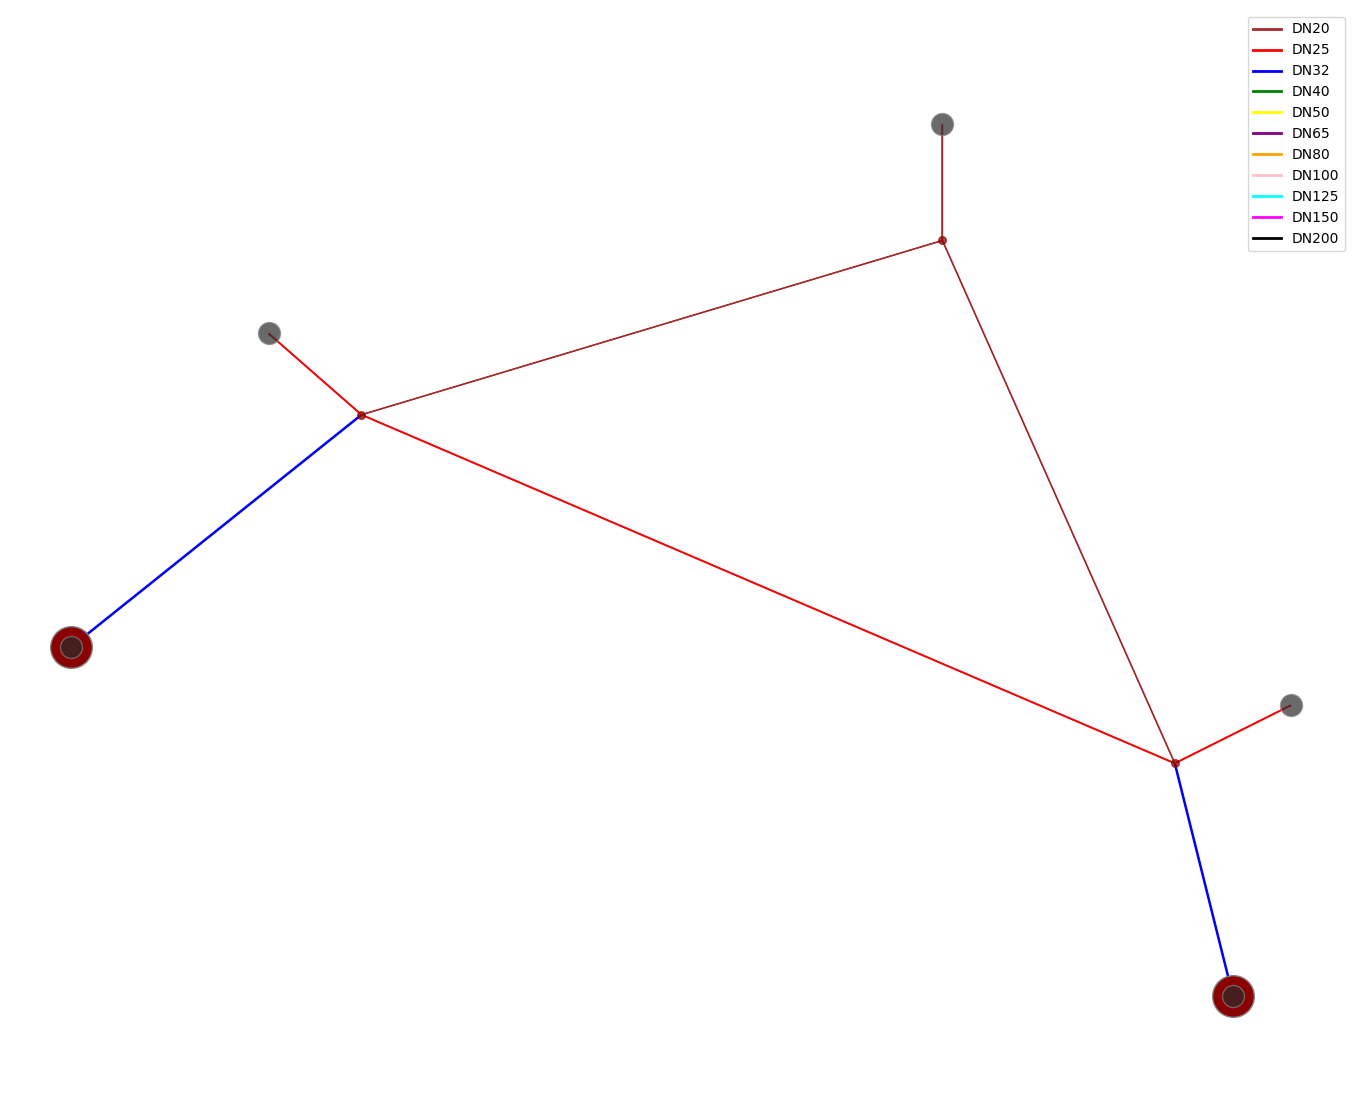

✅ Diameter visualization completed!
Legend shows DN (Nominal Diameter) classifications
Line thickness represents actual pipe diameter


In [11]:
print("=== Visualizing Pipe Diameters ===")

# Check if we have diameter data from the sizing
if 'graph_sized' in locals() and any('diameter' in graph_sized.edges[e] for e in graph_sized.edges):
    import uesgraphs.visuals as ug_vis
    
    # Create visualization object
    vis = ug_vis.Visuals(graph_sized)
    
    # Plot network with pipe diameters shown by line width and color
    scaling_factor = 10  # Adjust this to make diameter differences more visible
    
    print(f"Creating diameter visualization with scaling factor {scaling_factor}...")
    
    fig = vis.show_network(
        save_as=None,  # Set to "path/filename.png" if you want to save
        show_plot=True,
        scaling_factor=scaling_factor,
        show_diameters=True,  # This colors pipes by DN and shows diameter legend
        scaling_factor_diameter=50,  # Controls how thick the diameter lines appear
        dpi=150
    )
    
    print("✅ Diameter visualization completed!")
    print("Legend shows DN (Nominal Diameter) classifications")
    print("Line thickness represents actual pipe diameter")
    
else:
    print("❌ No diameter data available. Run the hydronic sizing first.")
    
    # Show how it would work with any graph that has diameter data
    print("\nExample usage (when diameter data is available):")
    print("""
    import uesgraphs.visuals as ug_vis
    
    # Create visualization object
    vis = ug_vis.Visuals(your_sized_graph)
    
    # Plot with diameters
    fig = vis.show_network(
        scaling_factor=15,
        show_diameters=True,
        scaling_factor_diameter=8
    )
    """)

## Best Practices & Recommended Workflow

Using temperature difference attribute: dT_Network
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\hydronic_network_sizing_20250526_170428.log
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\Visuals_20250526_170428.log


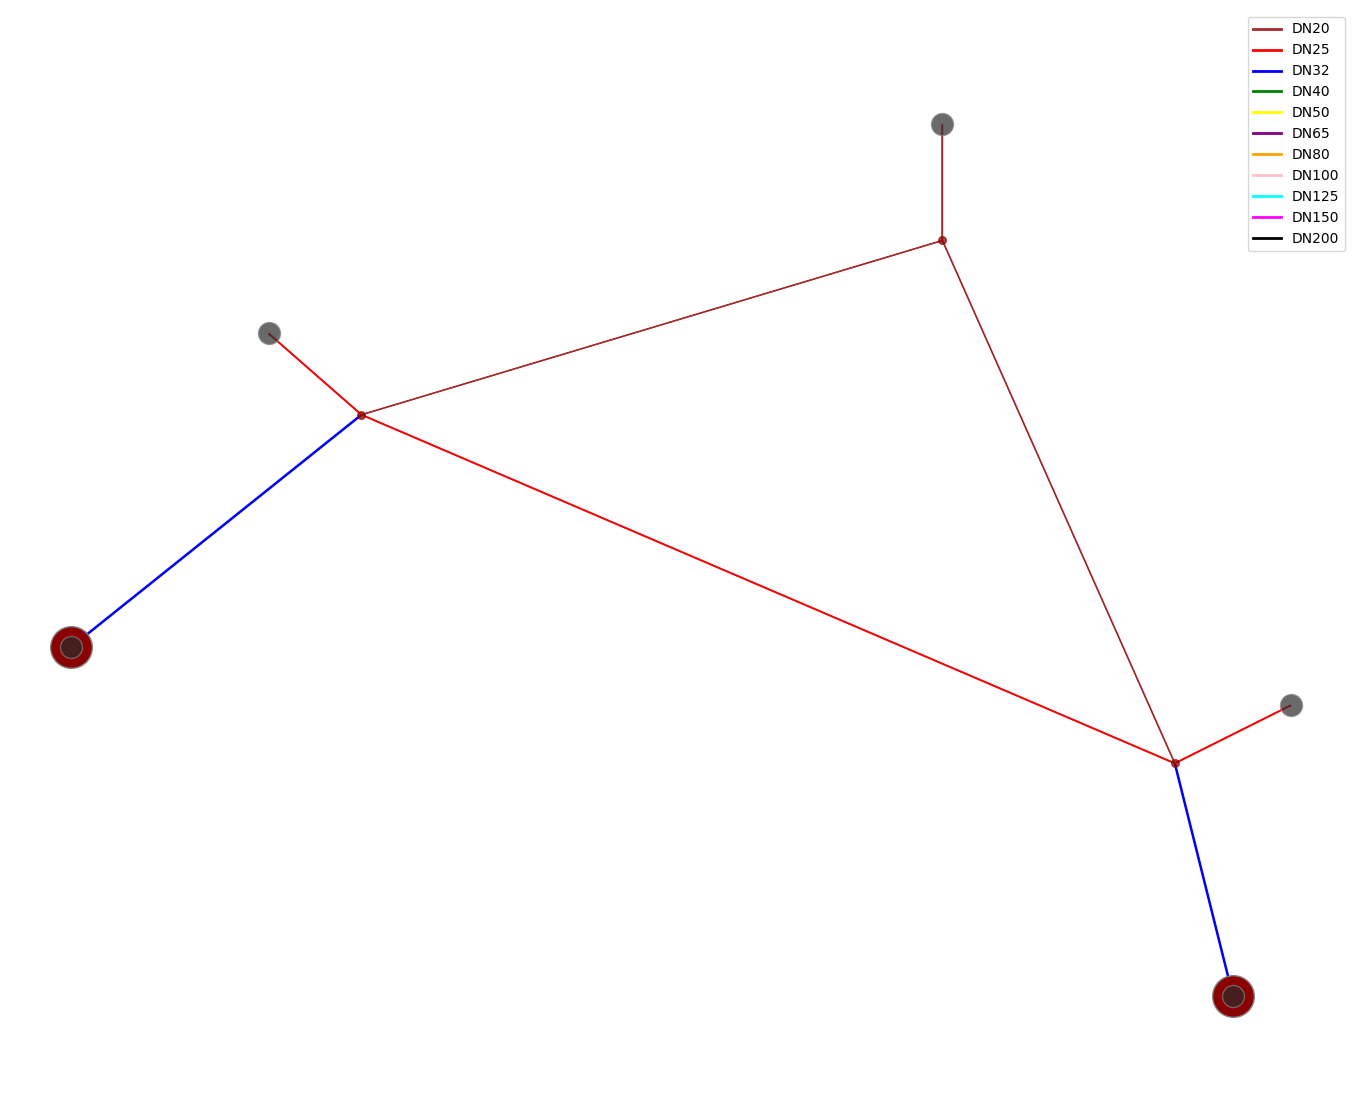

In [10]:
# Step 0: Load the network graph
#graph = ug.UESGraph()
#json = ...
#graph.from_json(path=json,network_type="heating")

# Step 1: Check if dT already exists, otherwise create it


dT_attr = "dT_design" if "dT_design" in graph.nodes[list(graph.nodelist_building)[0]] else "dT_Network"

for node in graph.nodelist_building:
    if not graph.nodes[node].get(f"is_supply_heating", False):
        if dT_attr not in graph.nodes[node]:
            graph.nodes[node][dT_attr] = 30.0  # Kelvin

print(f"Using temperature difference attribute: {dT_attr}")
for node in graph.nodelist_building:
    graph.nodes[node]["dT_design"] = 20.0
for node in graph.nodelist_building:
    if not graph.nodes[node].get(f"is_supply_heating", False):
        graph.nodes[node]["dT_Network"] = 30.0  # or your design value

# Step 2: For complete sizing (recommended)
# Option A: If you need to preserve the original graph
need_to_preserve_original = False  # Set to False if you don't need the original graph
if need_to_preserve_original:
    import copy
    graph_for_sizing = copy.deepcopy(graph)
else:
    graph_for_sizing = graph

graph_final = sysm_ut.size_hydronic_network(
    graph=graph_for_sizing,
    catalog="isoplus",
    dT_attribute="dT_Network", 
    load_scenario="peak_load"
)

# Step 3: Visualize the results
# Create visualization object
vis = ug_vis.Visuals(graph_final)

# Plot network with pipe diameters shown by line width and color
fig = vis.show_network(
    save_as=None,  # Set to "path/filename.png" if you want to save
    show_plot=True,
    scaling_factor=10,
    show_diameters=True,  # This colors pipes by DN and shows diameter legend
    scaling_factor_diameter=50,  # Controls how thick the diameter lines appear
    dpi=150
)
# Step 3: Analyze and validate results
# [Your analysis code here]

## 7. Summary

### What We've Accomplished

In this notebook, we've demonstrated:

✅ **Demand-based mass flow estimation** with different load scenarios  
✅ **Complete hydronic sizing** including pipe diameter selection  
✅ **Network visualization** showing pipe diameters
✅ **Best practices** for robust district heating network design  

### Key Results

- **Mass flow calculation**: Physically accurate flows based on individual node demands
- **Pipe sizing**: Automated DN selection using isoplus catalog
- **Visualization**: Clear representation of network hydraulics
- **Validation**: Error handling and result verification

### Next Steps

1. **Apply to your network**: Use the recommended workflow with your own data
2. **Experiment with parameters**: Try different temperature differences and load scenarios  
3. **Extend functionality**: Add custom pipe catalogs or modify calculation methods
4. **Integration**: Incorporate into your existing uesgraph workflows

Lets go! 🚀